# Introduction 

This notebook documents one of the two main classes of models for image inpainting and generation, a basic deep convolutional GAN.


# Initialization

## Imports

In [1]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
import lpips
from sklearn.model_selection import train_test_split
import time

# visualization
import matplotlib.pyplot as plt

# wandb
import wandb

# images
from skimage import io
from skimage import transform

# metrics
import torchmetrics


/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import custom methods

In [2]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import visualize_results, sample_batch

# Model

## Define model


 

In [13]:
class GatedConv2d(nn.Module):

    """
    This class implements a gated convolution. It works by applying a convolution filter 
    to the input feature tensor, then using the sigmoid function to map each score to a 
    pixel validity weight. The weights are then multiplied to the activation map from a 
    separate convolution filter.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation):
        super(GatedConv2d, self).__init__()
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation = dilation)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation = dilation)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, return_mask = False):

        mask = self.sigmoid(self.gate_conv(input_tensor))
        x = self.image_conv(input_tensor)
        x = torch.mul(x, mask) # apply mask

        if return_mask:
            return x, mask

        return x




class Conv2dBlock(nn.Module):

    def __init__(self, input_dim, output_dim, 
        kernel_size = 3, stride = 1, padding = 'same', dilation = 1, 
        activation = nn.ReLU, partial = True):

        super(Conv2dBlock, self).__init__()

        if partial:
            self.conv = GatedConv2d(input_dim, output_dim, kernel_size, stride, padding, dilation)
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, dilation)
        self.activation = activation()
        self.bn = nn.BatchNorm2d(output_dim)

    def forward(self, input_tensor):
        
        x = input_tensor
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        return x

class UpConv2dBlock(nn.Module):

    def __init__(self, input_dim, output_dim, 
        kernel_size = 3, stride = 1, padding = 'same', dilation = 1, 
        activation = nn.ReLU, 
        scale_factor = (2,2)):

        super(UpConv2dBlock, self).__init__()


        self.upsample = nn.Upsample(scale_factor = scale_factor, mode = 'nearest')
        self.conv = GatedConv2d(input_dim, output_dim, kernel_size, stride, padding, dilation)
        self.activation = activation()
        self.bn = nn.BatchNorm2d(output_dim)

    def forward(self, input_tensor):
        
        x = input_tensor
        x = self.upsample(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        return x

class LinearBlock(nn.Module):

    def __init__(self, input_dim, output_dim, activation = nn.ReLU):
        super(LinearBlock, self).__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = activation()
        self.bn = nn.BatchNorm1d(output_dim)

    def forward(self, input_tensor):
        
        x = input_tensor
        x = self.linear(x)
        x = self.bn(x)
        x = self.activation(x)

        return x


class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> downsample -> same -> downsample
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 8 x same conv
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv6 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv7 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv8 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv9 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv10 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1)
        self.conv13 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1)
        self.conv15 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

    def forward(self, input_tensor):

        x = self.conv0(input_tensor)
        
        # downsample
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)

        # upsample
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        return x


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation, partial = False)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation, partial = False)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation, partial = False)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation, partial = False)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation, partial = False)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x

def summary(model: nn.Module, verbose = False):
    count = 0
    if verbose:
        print(model)

    for name, params in model.named_parameters():
        num_params = params.flatten().size()[0]
        count += num_params
        if verbose:
            print(f"\nlayer: {name}")
            print(f"number of params: {num_params}")
            print(f"params shape: {params.size()}")

    print(f"model has {count/1e6} million parameters")


## Initialize model


In [14]:
# model parameters
image_dim = 96
in_channels = 4
out_channels = 3
hidden_channels = 64
activation = nn.PReLU

# create model
generator = Generator(in_channels, hidden_channels, out_channels, activation)
discriminator = Discriminator(out_channels, hidden_channels, image_dim, activation)

summary(generator)
summary(discriminator)

model has 1.116369 million parameters
model has 0.150726 million parameters


## Save model

In [24]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/GatedConvGAN"

# save path
MODEL_NAMES = {"generator": "PartialConvGAN_Generator_hidden64_prelu", 
                "discriminator": "PartialConvGAN_Discriminator_hidden64_prelu"}
SAVE_PATHS = {f"{key}" : f"{MODEL_FOLDER}/{val}" for key, val in MODEL_NAMES.items()}

# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [16]:
def mask_segmented_loss(output, target, mask, loss_function = nn.functional.l1_loss):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = loss_function # can use l1 loss or coarse to fine refinement


    def weighted_sum():
        MASKED_WEIGHT = 1
        UNMASKED_WEIGHT = 1

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    def only_masked():
        loss = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss, (-mask + 1))
        loss = torch.sum(loss)/torch.sum(-mask + 1)
        return loss

    def masked_with_unmaskedgt():
        img = (-mask + 1) * output + mask * target
        loss = LOSS(img, target, reduction = 'mean')
        return loss

    # only masked
    loss = only_masked()

    return loss


## Training parameters


In [17]:
# device
parallel = False
device = 'cuda:3'  
devices = [2, 3]

if not parallel:
    generator = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

In [25]:
# define training parameters
num_epochs = 20
batch_size = 64

# optimizer parameters
learning_rate = 1e-4

# balance loss
alpha = 0.01

generator_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate)
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = learning_rate)
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
generator_loss_function = mask_segmented_loss
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits


# wrap into dictionary
training_params = {
    "generator_model" : generator,
    "discriminator_model" : discriminator,
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "generator_optimizer" : generator_optimizer,
    "generator_scheduler" : generator_scheduler,
    "generator_loss_function" : generator_loss_function,
    "discriminator_optimizer" : discriminator_optimizer,
    "discriminator_scheduler" : discriminator_scheduler,
    "discriminator_loss_function" : discriminator_loss_function,
    "alpha": alpha,
    "schedule_every" : 1,
    "save_path" : SAVE_PATHS,
    "sample_size" : 16,
    "log_every" : 20
}



## Metrics

In [19]:
# instantiate metric objects if needed
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)

# define metrics
metrics = {
    "Peak SnR" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (-mask + 1) + gt * mask, gt),
    "L2 loss" : lambda img, gt, mask : nn.functional.mse_loss(img * (-mask + 1) + gt * mask, gt),
    "L1 loss" : lambda img, gt, mask : nn.functional.l1_loss(img * (-mask + 1) + gt * mask, gt),
    "learned perceptual image patch similarity" : (lambda img, gt, mask : VGG_LPIPS(img * (-mask + 1) + gt * mask, gt).mean())
}


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


## Load Frogs dataset

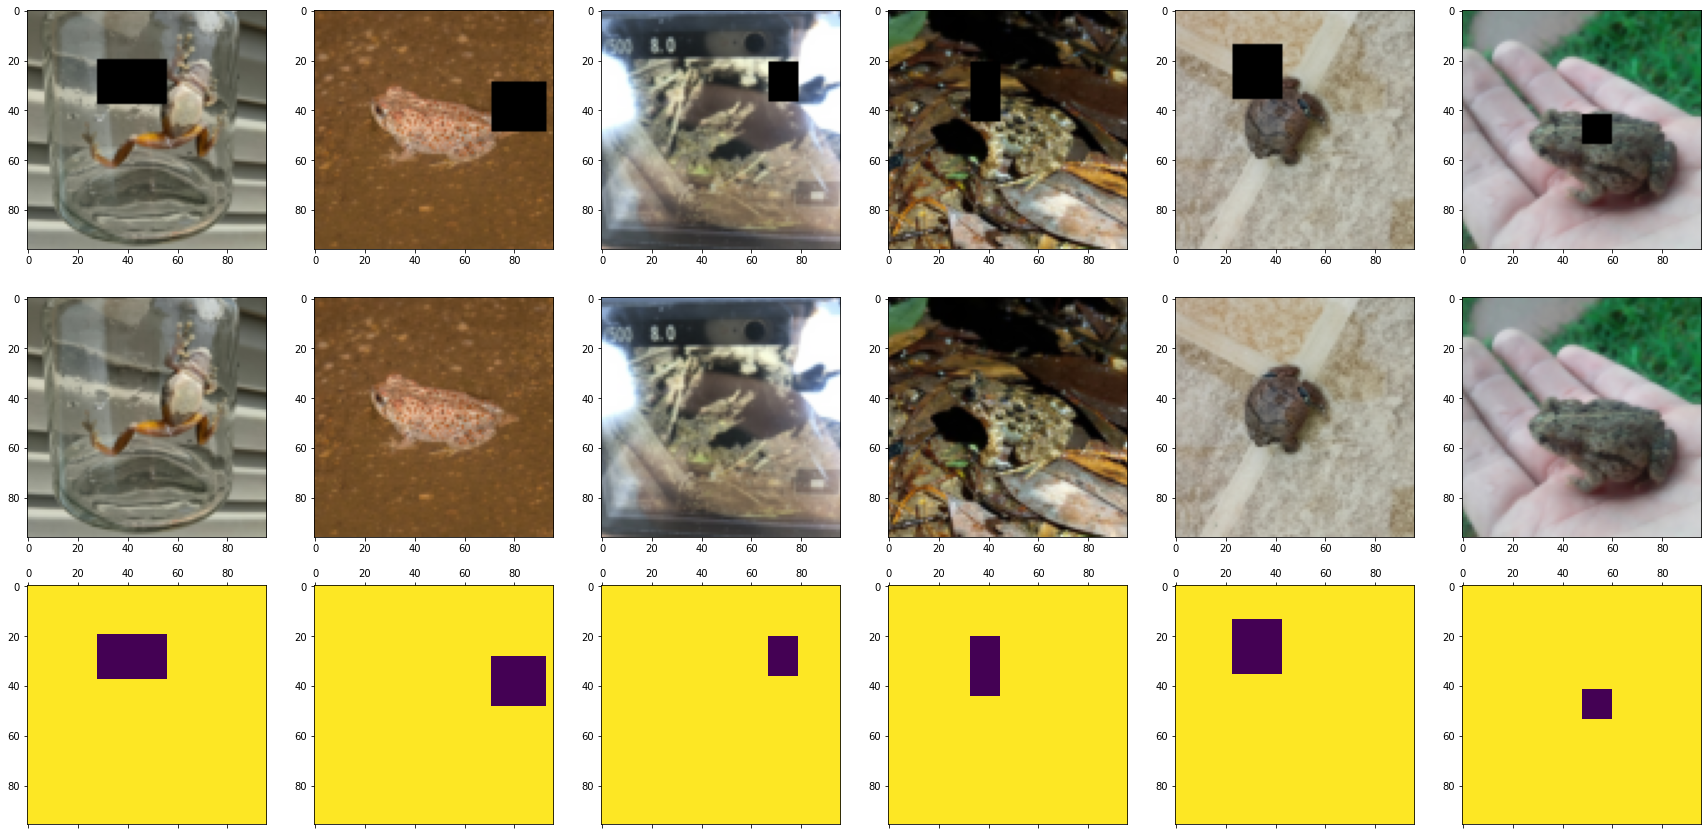

In [20]:
concat_mask = True
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/preprocessed_96",
                        file_prefix = "frog_",
                        image_dimension = image_dim,
                        concat_mask = concat_mask,
                        require_init = False,
                        drops = [3839])

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)

sample_batch(dataset, sample_size = 6)

In [21]:
# training config file
config = {
    "model_names" : MODEL_NAMES,
    "model_descriptions" : {
        "generator": "Follows GLCIC model, but simplified and without dilated convolutions. Gated convolutions used instead of convolutions.",
        "discriminator": "Follows GLCIC model, but with kernel size of 3, not 5."
    },
    "dataset_details" : {
        "img_dim" : image_dim,
        "indices_file" : "frogs_wanted_indices_url.txt",
        "random_crop" : True,
        "concat_mask" : True
    },
    "train_details" : {
        "num_epochs" : num_epochs,
        "batch_size" : batch_size, 
        "learning_rate": learning_rate,
        "optimizer" : "ADAM",
        "scheduler" : {
            "name" : "ReduceLROnPlateau",
            "params" : ['min', 0.5, 3, 1e-6],
        "schedule_every" : 1,
        "alpha" : alpha
        },
        "loss_functions" : {
            "description" : "Generator uses l1 masked reconstruction loss. Discrimnator binary cross entropy loss. Weighted by alpha.",
        },
    }
}

# wandb logging
wandb.init(project="GatedConvGAN", entity="cs4243_project")
wandb.config = config

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Training

## Helper functions

In [27]:
import torchvision

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    GENERATOR_LOSS_FUNCTION = training_params["generator_loss_function"]
    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]
    BATCH_EVALUATE_EVERY = 1
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    ALPHA = training_params["alpha"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for index, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # Set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()
            DISCRIMINATOR_OPTIMIZER.zero_grad()

            # ===== FORWARD PASS =====
            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. forward pass by generator to produce images
            input_batched.requires_grad_()
            output_batched = generator(input_batched)

            # 3. splice generated images to that patch is only change
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 4. generate labels for discriminator
            b, _, _, _ = input_batched.shape
            label_real = torch.ones(b, 1).to(device)
            label_fake = torch.zeros(b, 1).to(device)

            # 5. forward and backward pass on discriminator
            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)
            pred_fake = discriminator(spliced_batched)
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 6. adverserial and reconstruction loss on generator, repeated for computation graph
            # 6.1 forward pass by generator to produce images, splice them
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 6.2 reconstruction and adverserial loss
            loss_g_reconstruction = GENERATOR_LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_fake)* -1
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses
            loss = loss_g + loss_d * ALPHA
            running_results["loss"] += loss.detach().item()
            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: Reconstructed, 4th row: spliced")
                wandb.log( {
                    "images" : images,
                    "loss" : loss.detach().item(),
                    "loss_generator": loss_g.detach().item(),
                    "loss_discriminator" : loss_d.detach().item(),
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })
        

            # ===== HOUSEKEEPING =====
            del loss
            del loss_g
            del loss_d
            del input_batched
            del output_batched
            del spliced_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, val in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results



def evaluate_epoch(model, device, validation_dataloader, training_params : dict, metrics : dict):

    # ===== INITIALIZE =====
    # constants
    LOSS_FUNCTION = training_params["generator_loss_function"]

    # to device
    model = model.to(device)

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_generator"] = 0.0

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        model.eval()
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = model(input_batched)

            # 3. evaluate
            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched).detach().item()
            running_results["loss_generator"] += loss
            
            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # delete to ensure memory footprint
            del loss
            del input_batched
            del output_batched

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= batches

    return running_results

def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_path"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variables losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    train_results["loss"] = []
    train_results["loss_generator"] = []
    train_results["loss_discriminator"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    eval_results["loss"] = []
    eval_results["loss_generator"] = []
    eval_results["loss_discriminator"] = []


    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(generator, device, validation_dataloader, training_params, metrics)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["loss_generator"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["loss_generator"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Training

In [28]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(device, train_dataset, validation_dataset, training_params, metrics, log_wandb = True)


===== Epoch: 1 ===== 
188/188: Peak SnR: 31.37202589562599   L2 loss: 0.0007393949779996431   L1 loss: 0.0037886362158733003   learned perceptual image patch similarity: 0.04245512064625608   loss: 0.27392060452319206   loss_discriminator: 0.13834719137942536   loss_generator: 0.26008588527428345    
47/47: Peak SnR: 32.04637685735175   L2 loss: 0.0006293517412330479   L1 loss: 0.003392853050869196   learned perceptual image patch similarity: 0.03862305667172087   loss_generator: 0.2944880768339685      
Completed epoch 1! Took 3.02260578473409 min
Saved models!

===== Epoch: 2 ===== 
188/188: Peak SnR: 31.8624772924058   L2 loss: 0.0006587905361889267   L1 loss: 0.003520496857124678   learned perceptual image patch similarity: 0.039871130099004885   loss: 0.24952282645600907   loss_discriminator: 0.13640226835900165   loss_generator: 0.23588259930306293      
47/47: Peak SnR: 32.28865144607869   L2 loss: 0.0005944177608669518   L1 loss: 0.003257896013042711   learned perceptual image

In [ ]:
running_train_results, running_eval_results = train_evaluate(device, train_dataset, validation_dataset, training_params, metrics, start_epoch = num_epochs, log_wandb = True)

# Results and analysis

In [ ]:
visualize_results(generator, device, running_train_results, running_eval_results, test_dataset = validation_dataset)

In [ ]:
SAMPLE_SIZE = 24
loader = DataLoader(train_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
batch = next(iter(loader))

# predict and plot
generator.eval()
output = generator(batch["image"].to(device).permute(0, 3, 1, 2))
generator.train()

high = output.max().detach().cpu()
low = output.min().detach().cpu()
output =(output.detach().cpu().permute(0, 2, 3, 1))
mask = batch["mask"].detach().cpu()
output = (1-mask) * output + mask * batch["reconstructed"].detach().cpu()
fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
for i in range(SAMPLE_SIZE):
    image = batch["image"][i]
    reconstructed = batch["reconstructed"][i]
    predicted = output[i]

    if image.shape[-1] > 3: 
        image = image[:, :, 0:3] # take rgb if more than 3 channels
        
    ax[0][i].imshow(image)
    ax[1][i].imshow(reconstructed)
    ax[2][i].imshow(predicted)
    
plt.show()